<a href="https://colab.research.google.com/github/sthalles/SimCLR/blob/master/feature_eval/linear_feature_eval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install gdown

In [16]:
# folder_name = 'resnet-18_80-epochs'

# # !gdown https://drive.google.com/uc?id=1c4eVon0sUd-ChVhH6XMpF6nCngNJsAPk # ResNet 18 --> 40 epochs trained
# !gdown https://drive.google.com/uc?id=1L0yoeY9i2mzDcj69P4slTWb-cfr3PyoT # ResNet 18 --> 80 epochs trained
# !unzip resnet-18_80-epochs
# !ls

In [2]:
!ls ../

LICENSE.txt  config.yaml  env.yml	models		  runs
README.md    data	  feature_eval	requirements.txt  simclr.py
__pycache__  data_aug	  loss		run.py		  simclr_icm.py


In [3]:
# download and extract stl10
# !wget http://ai.stanford.edu/~acoates/stl10/stl10_binary.tar.gz
# !tar -zxvf stl10_binary.tar.gz
# !ls

In [4]:
import torch
import sys
import numpy as np
import os
from sklearn.neighbors import KNeighborsClassifier
import yaml
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
import importlib.util

from torchvision import datasets
import torchvision.transforms as transforms

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)

Using device: cuda


In [6]:
# checkpoints_folder = os.path.join(folder_name, 'checkpoints')
folder_name = 'Dec16_05-29-52_figure'
checkpoints_folder = os.path.join('../runs/' + folder_name, 'checkpoints')
config = yaml.load(open(os.path.join(checkpoints_folder, "config.yaml"), "r"))
config

/userhome/ydjiang/miniconda3/envs/simclr/lib/python3.7/site-packages/ipykernel_launcher.py:4: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  after removing the cwd from sys.path.


{'batch_size': 512,
 'epochs': 80,
 'eval_every_n_epochs': 1,
 'fine_tune_from': 'None',
 'log_every_n_steps': 50,
 'weight_decay': '10e-6',
 'fp16_precision': False,
 'exp_type': 'normal',
 'augmentor_type': 'cnn',
 'normalization_type': 'spectral',
 'num_mechanisms': 8,
 'simclr_train_interval': 1,
 'optimizer': 'adam',
 'device': 'cuda',
 'model': {'out_dim': 256, 'base_model': 'resnet18'},
 'dataset': {'s': 1,
  'input_shape': '(96,96,3)',
  'num_workers': 0,
  'valid_size': 0.05,
  'use_augmentation': True,
  'name': 'CIFAR10'},
 'loss': {'temperature': 0.5, 'use_cosine_similarity': True}}

In [7]:
checkpoints_folder

'../runs/Dec16_05-29-52_figure/checkpoints'

In [8]:
def _load_stl10(prefix="train"):
    X_train = np.fromfile('./stl10_binary/' + prefix + '_X.bin', dtype=np.uint8)
    y_train = np.fromfile('./stl10_binary/' + prefix + '_y.bin', dtype=np.uint8)

    X_train = np.reshape(X_train, (-1, 3, 96, 96)) # CWH
    X_train = np.transpose(X_train, (0, 1, 3, 2)) # CHW

    print("{} images".format(prefix))
    print(X_train.shape)
    print(y_train.shape)
    return X_train, y_train - 1

def _load_cifar10(prefix="train"):
    train_dataset = datasets.CIFAR10(
            "./data",
            download=True,
            train=prefix=="train",
            transform=transforms.Compose([transforms.ToTensor()])
        )
    image_batches, label_batches = [], []
    for i in range(len(train_dataset)): # or i, image in enumerate(dataset)
        images, labels = train_dataset[i]
        image_batches.append(images.numpy())
        label_batches.append(labels)
    image_batches, label_batches = np.array(image_batches), np.array(label_batches)
    print("{} images".format(prefix))
    print(image_batches.shape)
    print(label_batches.shape)
    print("max label", np.max(label_batches))
    return image_batches, label_batches

In [9]:
# load STL-10 train data
# X_train, y_train = _load_stl10("train")
X_train, y_train = _load_cifar10("train")

Files already downloaded and verified
train images
(50000, 3, 32, 32)
(50000,)
max label 9


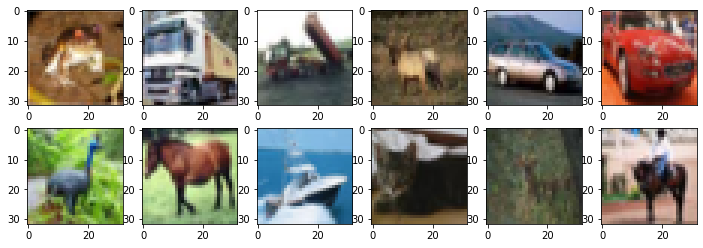

In [10]:
fig, axs = plt.subplots(nrows=2, ncols=6, constrained_layout=False, figsize=(12,4))

for i, ax in enumerate(axs.flat):
  ax.imshow(X_train[i].transpose(1,2,0))
plt.show()

In [11]:
# load STL-10 test data
# X_test, y_test = _load_stl10("test")
X_test, y_test = _load_cifar10("test")

Files already downloaded and verified
test images
(10000, 3, 32, 32)
(10000,)
max label 9


## Test protocol #1 PCA features

In [57]:
scaler = preprocessing.StandardScaler()
scaler.fit(X_train.reshape((X_train.shape[0],-1)))

pca = PCA(n_components=config['model']['out_dim'])

X_train_pca = pca.fit_transform(scaler.transform(X_train.reshape(X_train.shape[0], -1)))
X_test_pca = pca.transform(scaler.transform(X_test.reshape(X_test.shape[0], -1)))

print("PCA features")
print(X_train_pca.shape)
print(X_test_pca.shape)

PCA features
(50000, 256)
(10000, 256)


In [12]:
def linear_model_eval(X_train, y_train, X_test, y_test):
    
    clf = LogisticRegression(random_state=0, max_iter=1200, solver='lbfgs', C=1.0)
    clf.fit(X_train, y_train)
    print("Logistic Regression feature eval")
    print("Train score:", clf.score(X_train, y_train))
    print("Test score:", clf.score(X_test, y_test))
    
    print("-------------------------------")
    neigh = KNeighborsClassifier(n_neighbors=10)
    neigh.fit(X_train, y_train)
    print("KNN feature eval")
    print("Train score:", neigh.score(X_train, y_train))
    print("Test score:", neigh.score(X_test, y_test))

In [ ]:
linear_model_eval(X_train_pca, y_train, X_test_pca, y_test)

## clean up resources
del X_train_pca
del X_test_pca

Logistic Regression feature eval
Train score: 0.43046
Test score: 0.4094
-------------------------------
KNN feature eval


## Protocol #2 Logisitc Regression

In [13]:
# Load the neural net module
# spec = importlib.util.spec_from_file_location("model", os.path.join(checkpoints_folder, 'resnet_simclr.py'))
# spec = importlib.util.spec_from_file_location("../models", 'resnet_simclr.py')
# resnet_module = importlib.util.module_from_spec(spec)
# spec.loader.exec_module(resnet_module)
# from SimCLR import ResNetSimCLR
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

class ResNetSimCLR(nn.Module):

    def __init__(self, base_model, out_dim):
        super(ResNetSimCLR, self).__init__()
        self.resnet_dict = {"resnet18": models.resnet18(pretrained=False),
                            "resnet50": models.resnet50(pretrained=False)}

        resnet = self._get_basemodel(base_model)
        num_ftrs = resnet.fc.in_features

        self.features = nn.Sequential(*list(resnet.children())[:-1])

        # projection MLP
        self.l1 = nn.Linear(num_ftrs, num_ftrs)
        self.l2 = nn.Linear(num_ftrs, out_dim)

    def _get_basemodel(self, model_name):
        try:
            model = self.resnet_dict[model_name]
            print("Feature extractor:", model_name)
            return model
        except:
            raise ("Invalid model name. Check the config file and pass one of: resnet18 or resnet50")

    def forward(self, x):
        h = self.features(x)
        h = h.squeeze()

        x = self.l1(h)
        x = F.relu(x)
        x = self.l2(x)
        return h, x

In [14]:
model = ResNetSimCLR(**config['model'])
model.eval()

state_dict = torch.load(os.path.join(checkpoints_folder, 'model.pth'), map_location=torch.device('cpu'))
model.load_state_dict(state_dict)
model = model.to(device)

Feature extractor: resnet18


In [15]:
def next_batch(X, y, batch_size):
    for i in range(0, X.shape[0], batch_size):
        X_batch = torch.tensor(X[i: i+batch_size]) / 255.
        y_batch = torch.tensor(y[i: i+batch_size])
        yield X_batch.to(device), y_batch.to(device)

In [16]:
X_train_feature = []

for batch_x, batch_y in next_batch(X_train, y_train, batch_size=config['batch_size']):
    features, _ = model(batch_x)
    X_train_feature.extend(features.cpu().detach().numpy())
    
X_train_feature = np.array(X_train_feature)

print("Train features")
print(X_train_feature.shape)

Train features
(50000, 512)


In [17]:
X_test_feature = []

for batch_x, batch_y in next_batch(X_test, y_test, batch_size=config['batch_size']):
    features, _ = model(batch_x)
    X_test_feature.extend(features.cpu().detach().numpy())
    
X_test_feature = np.array(X_test_feature)

print("Test features")
print(X_test_feature.shape)

Test features
(10000, 512)


In [18]:
scaler = preprocessing.StandardScaler()
scaler.fit(X_train_feature)

linear_model_eval(scaler.transform(X_train_feature), y_train, scaler.transform(X_test_feature), y_test)

del X_train_feature
del X_test_feature

/userhome/ydjiang/miniconda3/envs/simclr/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Logistic Regression feature eval
Train score: 0.49784
Test score: 0.4796
-------------------------------
KNN feature eval
Train score: 0.493
Test score: 0.38
